## Mega matrix with disattenuation applied

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy as sp
import scipy.stats as stats
import nibabel as nibabel
import pandas as pd
import nibabel.freesurfer.mghformat as mgh
import scipy.io
import itertools 
import pickle

In [2]:
data_dir = '../../../data/'
local_data_dir = '../../../local_data/'

subjid = ['01', '02', '03', '04', '05', '06', '07', '08']
ROI_names = ['Unknown', 'Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']
n_repeats = 3

#threshold for voxels (based on split-half reliability)
thresh = 0.2

In [3]:
#get ROI data
rh_streams = []
for sidx, sid in enumerate(subjid):
    mgh_file = mgh.load(data_dir+'nsddata/freesurfer/subj'+ sid +'/label/rh.streams.mgz')
    rh_streams.append(mgh_file.get_fdata()[:,0,0])

In [4]:
#get voxel level split-half reliability data
reliability = []
for sidx, sid in enumerate(subjid):
    
    sh_dir = local_data_dir + 'freesurfer/subj' + sid + '/rh_split_half.mat'
    sh = scipy.io.loadmat(sh_dir)
    
    reliability.append(sh['mean'])

In [5]:
#get organized z-scored betas
with open(local_data_dir + 'processed/rh_betas_by_repeat_by_ROI_zscore.data', 'rb') as filehandle:
    # read the data as binary data stream
    rh_betas_by_repeat_by_ROI = pickle.load(filehandle)

In [6]:
# Replace voxels with split-half reliability < thresh with NaNs and then trim those from data structure

sh_by_ROI = [[[] for j in range(len(ROI_names)-1)] for i in range(len(subjid))]
total_vox = np.zeros((len(subjid), len(ROI_names)-1))

#organize
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1):       
        sh_by_ROI[sidx][roi_idx]=reliability[sidx][:,rh_streams[sidx] == roi_idx+1]
        total_vox[sidx,roi_idx] = len(sh_by_ROI[sidx][roi_idx][0])

#convert to nans
for sidx, sid in enumerate(subjid):  
    for roi_idx in range(len(ROI_names)-1): 
        for vox in range(len(sh_by_ROI[sidx][roi_idx][0])):
            if sh_by_ROI[sidx][roi_idx][0][vox] < thresh:
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][0][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][1][:,vox]=np.nan
                rh_betas_by_repeat_by_ROI[sidx][roi_idx][2][:,vox]=np.nan    

thresh_vox = np.zeros((len(subjid), len(ROI_names)-1))
                
#trim out nans
for sidx, sid in enumerate(subjid):   
    for roi_idx in range(len(ROI_names)-1): 
        for r in range(n_repeats):
            temp = rh_betas_by_repeat_by_ROI[sidx][roi_idx][r]
            trimmed = temp[:,~np.all(np.isnan(temp), axis=0)]

            rh_betas_by_repeat_by_ROI[sidx][roi_idx][r] = trimmed
        thresh_vox[sidx,roi_idx] = trimmed.shape[1]

#gather number of remaining voxels for each ROI and subj
vox = np.zeros((len(ROI_names)-1, len(subjid)))
for roi_idx in range(len(ROI_names)-1):
    vox[roi_idx,:] = [rh_betas_by_repeat_by_ROI[sidx][roi_idx][0].shape[1] for sidx, sid in enumerate(subjid)]        

In [7]:
# Create RSMS for all the ROIs, repeats and subjects

tril_flat_shape = int((rh_betas_by_repeat_by_ROI[0][0][0].shape[0]**2/2) - (rh_betas_by_repeat_by_ROI[0][0][0].shape[0]/2))
flat_rsm = np.zeros((len(subjid),len(ROI_names)-1, tril_flat_shape, n_repeats))
rsm = np.zeros((len(subjid),len(ROI_names)-1,n_repeats,rh_betas_by_repeat_by_ROI[0][0][0].shape[0],rh_betas_by_repeat_by_ROI[0][0][0].shape[0]))

for sidx, sid in enumerate(subjid):
    
    for roi_idx in range(len(ROI_names)-1):
        voxels = np.min(vox[roi_idx,:])
        
        for r in range(n_repeats):
            rsm[sidx,roi_idx,r,:,:] = np.corrcoef(rh_betas_by_repeat_by_ROI[sidx][roi_idx][r])
            lower = np.tril(rsm[sidx,roi_idx,r,:,:], -1).T.ravel() #only need lower triangle without diagonal
            flat_rsm[sidx, roi_idx, :,r] = lower[lower != 0] #flatten into vectors

In [8]:
r1_trial_order = [0, 0, 0, 1, 1, 1, 2, 2, 2]
r2_trial_order = [0, 1, 2, 0, 1, 2, 0, 1, 2]

#don't use same trials when same subject
ss_r1_trial_order = [0, 0, 1, 1, 2, 2]
ss_r2_trial_order = [1, 2, 0, 2, 0, 1]

In [9]:
total_combs = len(subjid) * (len(ROI_names)-1)
mega_matrix = np.zeros((total_combs,total_combs))
total_rsms_sh = np.zeros((len(subjid),len(ROI_names)-1))

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i%7 #roi
    sidx1 = i//7 #subject
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,0],flat_rsm[sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,0],flat_rsm[sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,1],flat_rsm[sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    total_rsms_sh[sidx1,roi_idx1]= np.mean(split_half)
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j%7 #roi
        sidx2 = j//7 #subject
        
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(flat_rsm[sidx2,roi_idx2,:,0],flat_rsm[sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(flat_rsm[sidx2,roi_idx2,:,0],flat_rsm[sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(flat_rsm[sidx2,roi_idx2,:,1],flat_rsm[sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             flat_rsm[sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,r1_trial_order[r]],
                                             flat_rsm[sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        

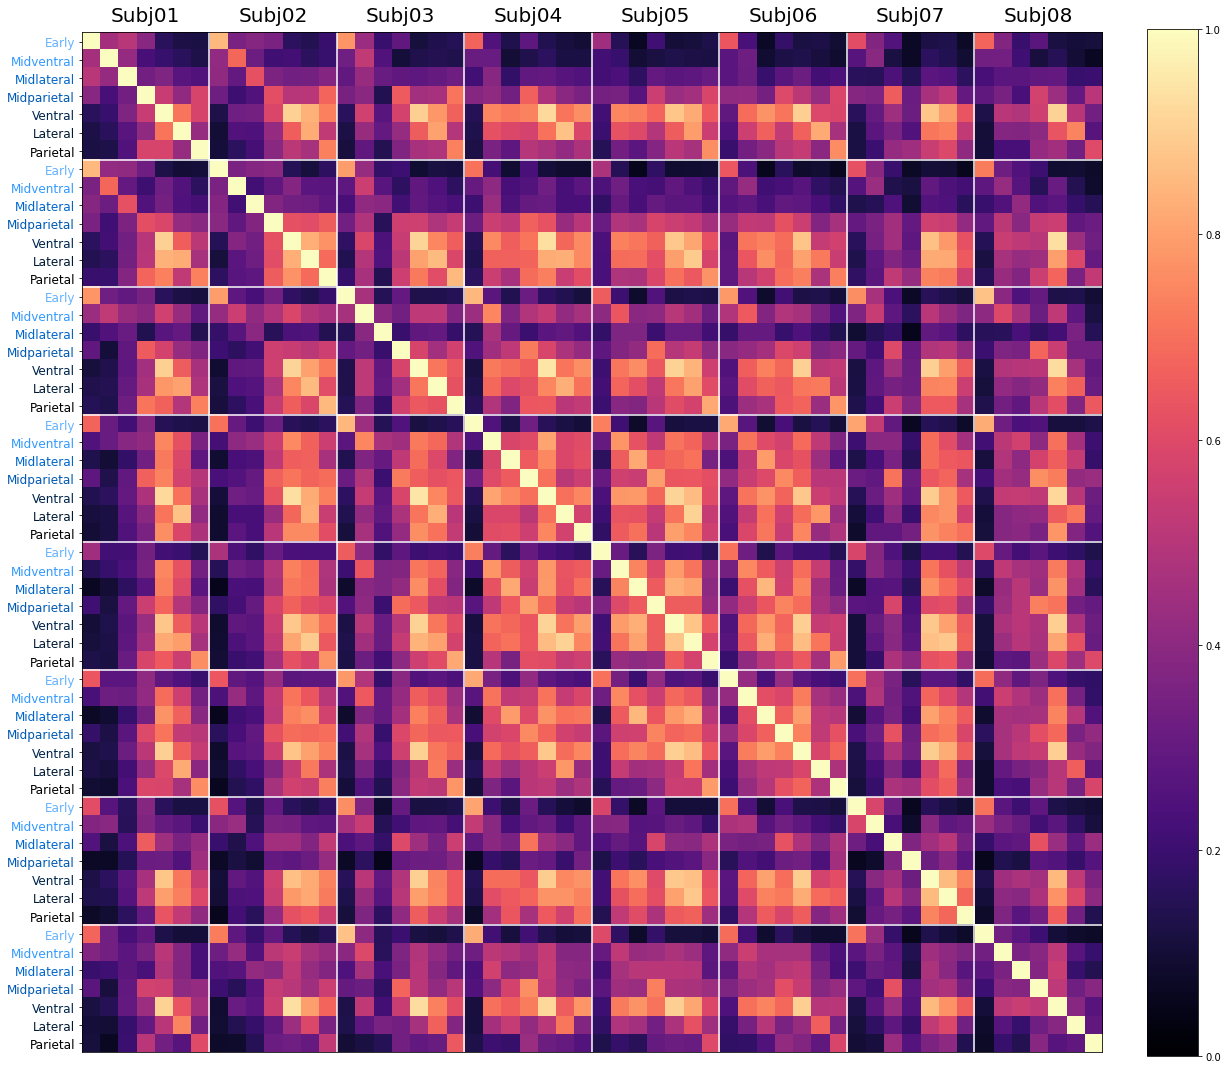

In [10]:
plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix,
           cmap='magma')

x_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
y_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks = np.arange(0+3, 56+3,7)
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 8), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000']
for i in range(56):
    r = i%7
    plt.gca().get_yticklabels()[i].set_color(colors[r])

plt.axvline(x=6.5, c='w')
plt.axvline(x=13.5, c='w')
plt.axvline(x=20.5, c='w')
plt.axvline(x=27.5, c='w')
plt.axvline(x=34.5, c='w')
plt.axvline(x=41.5, c='w')
plt.axvline(x=48.5, c='w')


plt.axhline(y=6.5, c='w')
plt.axhline(y=13.5, c='w')
plt.axhline(y=20.5, c='w')
plt.axhline(y=27.5, c='w')
plt.axhline(y=34.5, c='w')
plt.axhline(y=41.5, c='w')
plt.axhline(y=48.5, c='w')

plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_adjusted_both_noabs_rh.png')



In [11]:
np.min(mega_matrix)

0.054123430121853354

In [12]:
total_rsms_sh[:,5]

array([0.22361267, 0.28829901, 0.2497917 , 0.15346584, 0.38006357,
       0.13533599, 0.22095952, 0.06501453])

In [13]:
np.mean(total_rsms_sh,axis=0)

array([0.28111939, 0.26511254, 0.21989127, 0.19345382, 0.51299095,
       0.21456785, 0.17053504])

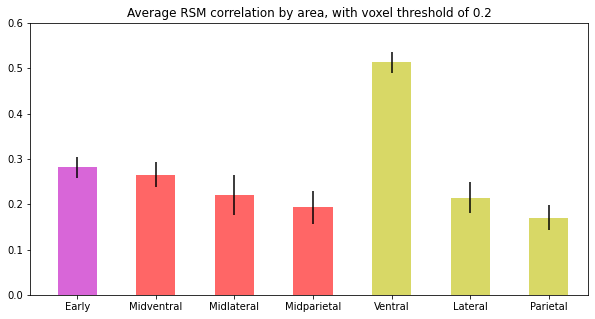

In [14]:
data = np.mean(total_rsms_sh,axis=0)
error = stats.sem(total_rsms_sh, axis=0)

plt.figure(figsize=(10, 5))
xlocations = np.array(range(len(data)))+.1
width = 0.5
plt.bar(xlocations, data, 
        yerr=error, width=width, color = ['m','r','r','r','y','y','y'], alpha = .6)
plt.xticks(xlocations, ROI_names[1:])
plt.xlim(-0.5, xlocations[-1]+width)
plt.title("Average RSM correlation by area, with voxel threshold of " + str(thresh))
plt.gca().get_yaxis().tick_left()
plt.gca().get_xaxis().tick_bottom()
plt.ylim(0,0.6)

plt.savefig('../../../results/figures/sh_RSM_withinROI_withinSubj_voxThresh' + str(int(thresh*100)) + '_rh.png')


In [15]:
subj_idx = np.arange(0,len(subjid))
subj_combs = list(itertools.combinations(subj_idx, 2))

print(subj_combs)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


In [16]:
vent2vent = []
lat2lat = []
vent2lat = []
lat2vent = []

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i%7 #roi
    sidx1 = i//7 #subject
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j%7 #roi
        sidx2 = j//7 #subject
        
        if (sum([(sidx1==comb[0] and sidx2==comb[1]) for comb in subj_combs]))>0: #check that we're in lower triangle
            
            if (roi_idx1 == 4 and roi_idx2 == 4):
                vent2vent.append(mega_matrix[i,j])
            elif (roi_idx1 == 5 and roi_idx2 == 5):
                lat2lat.append(mega_matrix[i,j])
            elif (roi_idx1 == 4 and roi_idx2 == 5):
                vent2lat.append(mega_matrix[i,j])
            elif (roi_idx1 == 5 and roi_idx2 == 4):
                lat2vent.append(mega_matrix[i,j])


In [17]:
print(np.mean(vent2vent))
print(np.mean(lat2lat))
print(np.mean([vent2lat, lat2vent]))


0.9021991000828152
0.7658275083932722
0.6988934143548046


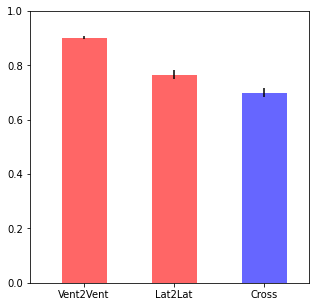

In [18]:
d = [np.mean(vent2vent), np.mean(lat2lat), np.mean(np.hstack((vent2lat, lat2vent)))]
error = [stats.sem(vent2vent, axis=0), stats.sem(lat2vent, axis=0), stats.sem(np.hstack((vent2lat, lat2vent)), axis=0)]

plt.figure(figsize=(5, 5))
xlocations = np.array(range(3))+.1
width = 0.5
plt.bar(xlocations, d, yerr=error, width=width, color = ['r','r','b'], alpha = .6)
plt.xticks(xlocations, ['Vent2Vent', 'Lat2Lat', 'Cross'])
plt.xlim(-0.5, xlocations[-1]+width)
plt.ylim(0,1)
#plt.title("Average RSM correlation by area")
plt.gca().get_yaxis().tick_left()
plt.gca().get_xaxis().tick_bottom()
plt.show()

In [19]:
## not guaranteed by analysis - for example, subj 1 ventral predicts other subj 2 mid ventral 
## better than subj 1 midventral predicts subj 2 midventral

midvent2midvent = []
midlat2midlat = []

vent2midvent = []
vent2midlat = []

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i%7 #roi
    sidx1 = i//7 #subject
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j%7 #roi
        sidx2 = j//7 #subject
        
        if (sum([(sidx1==comb[0] and sidx2==comb[1]) for comb in subj_combs]))>0: #check that we're in lower triangle
            
            if (roi_idx1 == 1 and roi_idx2 == 1):
                midvent2midvent.append(mega_matrix[i,j])
            elif (roi_idx1 == 2 and roi_idx2 == 2):
                midlat2midlat.append(mega_matrix[i,j])
            elif (roi_idx1 == 1 and roi_idx2 == 4) or (roi_idx1 == 4 and roi_idx2 == 1):
                vent2midvent.append(mega_matrix[i,j])
            elif (roi_idx1 == 2 and roi_idx2 == 4) or (roi_idx1 == 4 and roi_idx2 == 2):
                vent2midlat.append(mega_matrix[i,j])


In [20]:
print(np.mean(midvent2midvent))
print(np.mean(vent2midvent))

print(np.mean(midlat2midlat))
print(np.mean(vent2midlat))

0.4982143979357452
0.49096589786049866
0.36632640364025354
0.5006016571367689


In [21]:
np.mean(midvent2midvent)

0.4982143979357452

In [22]:
##switch the order of roi and subject

mega_matrix_flipped = np.zeros((total_combs,total_combs))

for i in range(total_combs): #rows - i.e. model candidate
    roi_idx1 = i//8 #roi
    sidx1 = i%8 #subject
    
    split_half = np.zeros((3))
    split_half = [stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,0],flat_rsm[sidx1,roi_idx1,:,1])[0],
                  stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,0],flat_rsm[sidx1,roi_idx1,:,2])[0],
                  stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,1],flat_rsm[sidx1,roi_idx1,:,2])[0]]
    NC_model = np.mean(split_half) * 100
    
    for j in range(total_combs): #columns - i.e. target data
        roi_idx2 = j//8 #roi
        sidx2 = j%8 #subject
        
        split_half = np.zeros((3))
        split_half = [stats.pearsonr(flat_rsm[sidx2,roi_idx2,:,0],flat_rsm[sidx2,roi_idx2,:,1])[0],
                      stats.pearsonr(flat_rsm[sidx2,roi_idx2,:,0],flat_rsm[sidx2,roi_idx2,:,2])[0],
                      stats.pearsonr(flat_rsm[sidx2,roi_idx2,:,1],flat_rsm[sidx2,roi_idx2,:,2])[0]]
        NC_target = np.mean(split_half) * 100
        
        if (sidx1 == sidx2): #within subject
            rsm_corr = np.zeros((6))
            for r in range(6):
                rsm_corr[r] = stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,ss_r1_trial_order[r]],
                                             flat_rsm[sidx2,roi_idx2,:,ss_r2_trial_order[r]])[0]
            mega_matrix_flipped[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)
        else: #between subject
            rsm_corr = np.zeros((9))
            for r in range(9):
                rsm_corr[r] = stats.pearsonr(flat_rsm[sidx1,roi_idx1,:,r1_trial_order[r]],
                                             flat_rsm[sidx2,roi_idx2,:,r2_trial_order[r]])[0]
            mega_matrix_flipped[i,j] = np.mean(rsm_corr) * np.sqrt(100/NC_model) * np.sqrt(100/NC_target)

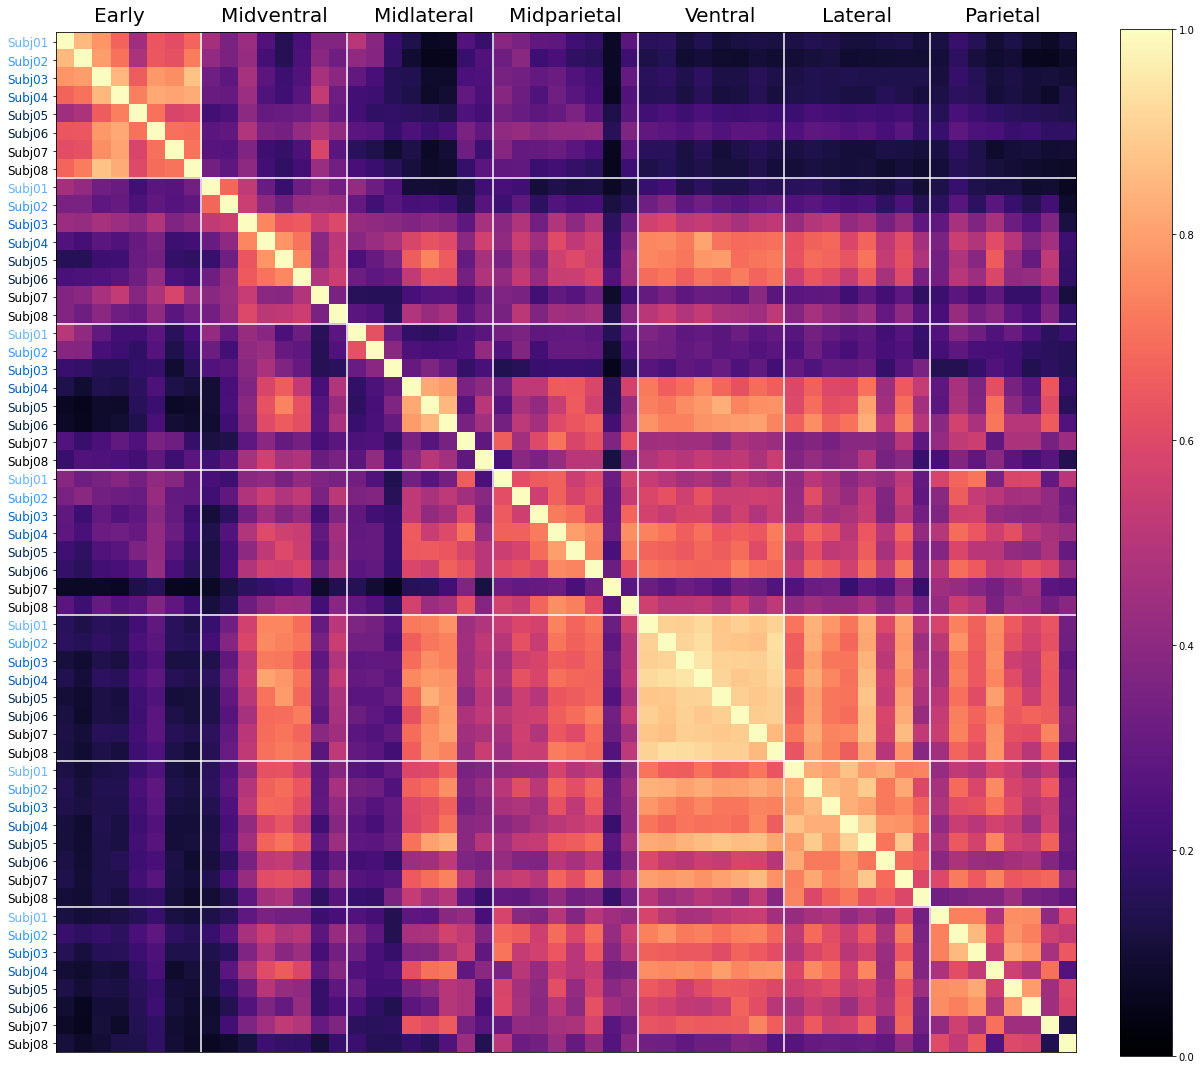

In [23]:
#plot flipped mega matrix

plt.figure(figsize=(20, 20))
plt.imshow(mega_matrix_flipped,
           cmap='magma')

y_labels = ['Subj01', 'Subj02', 'Subj03', 'Subj04', 'Subj05', 'Subj06', 'Subj07', 'Subj08']
x_labels = ['Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal']

x_ticks= np.array([3,11.5,19.75,27.5,36,43.5,51.5])
plt.xticks(x_ticks, x_labels, fontsize=20)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top = False, labeltop=True)

y_ticks = np.arange(0, 56)
plt.yticks(y_ticks, np.tile(y_labels, 7), fontsize='large')
colors = ['#66b3ff','#3399ff','#0066cc','#0059b3','#00264d','#001a33','#000000','#000000']
for i in range(56):
    r = i%8
    plt.gca().get_yticklabels()[i].set_color(colors[r])

plt.axvline(x=7.5, c='w')
plt.axvline(x=15.5, c='w')
plt.axvline(x=23.5, c='w')
plt.axvline(x=31.5, c='w')
plt.axvline(x=39.5, c='w')
plt.axvline(x=47.5, c='w')

plt.axhline(y=7.5, c='w')
plt.axhline(y=15.5, c='w')
plt.axhline(y=23.5, c='w')
plt.axhline(y=31.5, c='w')
plt.axhline(y=39.5, c='w')
plt.axhline(y=47.5, c='w')

plt.clim(0,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_adjusted_both_noabs_flipped_rh.png')



In [83]:
from sklearn.manifold import MDS
x, y = MDS(dissimilarity='precomputed').fit_transform(1-mega_matrix_flipped).T

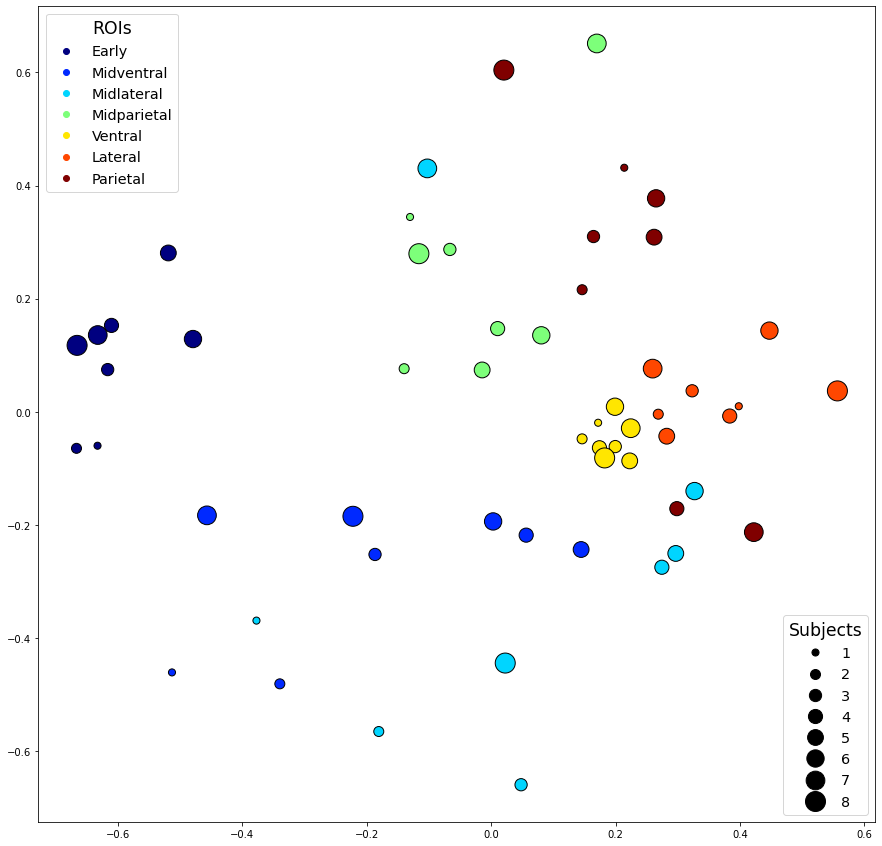

In [184]:
fig, ax = plt.subplots(figsize=(15, 15))

s = 50*np.array([[1,2,3,4,5,6,7,8]])
sizes = np.tile(s, 7)

c = np.array([[1,2,3,4,5,6,7]])
colors = np.repeat(c, 8)

rois =('Early', 'Midventral', 'Midlateral', 'Midparietal', 'Ventral', 'Lateral', 'Parietal')

scatter = ax.scatter(x, y, c=colors, s=sizes, edgecolors='k',cmap='jet') #'gnuplot2_r'

legend1 = plt.legend(handles=scatter.legend_elements()[0], labels=rois, 
                     loc="upper left", title="ROIs", title_fontsize = 'xx-large', fontsize='x-large')
ax.add_artist(legend1)

kw = dict(prop="sizes", num=8, color='k', fmt="{x:.0f}",
          func=lambda s: s/50)
legend2 = ax.legend(*scatter.legend_elements(**kw),
                    loc="lower right", title="Subjects", title_fontsize = 'xx-large', fontsize='x-large')

plt.show()

fig.savefig('../../../results/figures/megaMatrix_voxThresh' + str(int(thresh*100)) + '_MDS_rh.png')
